# Proejct 1: Edge Detection/Hough Transform

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions in parts A-B.

Please also fill in here the time that each part took you:
* A1. Gradient Magnitude: <span style="color:red;">45 min</span>
* A2. Gradient Orientation: <span style="color:red;">15 min</span>
* A3. Laplacian Zero-crossings: <span style="color:red;">30 min</span>
* A4. Gradient Magnitude + Zero-crossings: <span style="color:red;">30 min</span>
* B. Hough Transform (Circles):  <span style="color:red;">FILL IN TIME</span>

Note that the images referred to and needed for this project are contained in the zip file provided (in the same directory as this notebook file).  <i>Please use the files as though they are in the same directory.  We will drop your notebook file into our folder and run it.</i>

### Programming Exercises
Make sure to read through all of the assignment and plan accordingly.  The first part is relatively easy, but you should allow adequate time for the second part.

The main goal is to investigate edge detection and the Hough transform as discussed in Sections 4.2 and 4.3 of [Szeliski](http://szeliski.org/Book "Computer Vision: Algorithms and Applications").

#### Part A: Edge Detection (32 points)
For each of the following four parts, try out your code first on the <span style="color:orange;">2D_White_Box.png</span> image, then on the more complicated <span style="color:orange;">blocks.png</span> image.

Note: Many of the images will contain negative numbers or numbers larger than 255.  Make sure you approprately scale the output images to display all of the information.  Hint: try mapping negative values to [0,128) and positive values to (128,255].

2D_White_Box.png:
![alt 2D_White_Box.png](2D_White_Box.png)

blocks.png:
![alt blocks.png](blocks.png)

<br><br><b>A1. Gradient Magnitude</b> - Compute the gradient magnitude image for a grayscale image.  Apply a suitable threshold to find edge points--play with the threshold to find the "best" solution.  How well does this seem to work?  Feel free to use any preprocessing you wish to prior to edge detection.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

def convolution(image,kernel):
    size = kernel.shape[0]
    w = size//2
    h = size//2
    result = np.zeros(image.shape)

    for x in range (image.shape[0]):
        for y in range(image.shape[1]):
            vals = np.array(image[x-w:x+w+1,y-h:y+h+1])
            if vals.shape[0] == size and vals.shape[1] == size:
                vals *= kernel
                result[x,y] = np.sum(vals)

    return result

def sobelConv(image):
    sobX = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    sobY = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

    dX = convolution(image, sobX)/8
    dY = convolution(image, sobY)/8

    return dX, dY

def plotImage(image, title=""):
    im = np.array(image, dtype=np.uint8)
    plt.imshow(im, vmin = 0, vmax = 255, cmap='gray')
    plt.title(title)
    plt.show()


meanKernel = np.array([[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]])
blocks = plt.imread('blocks.png')
blocks = convolution(blocks, meanKernel)
blocks *= 255
blocks = np.array(blocks, dtype=np.int32)

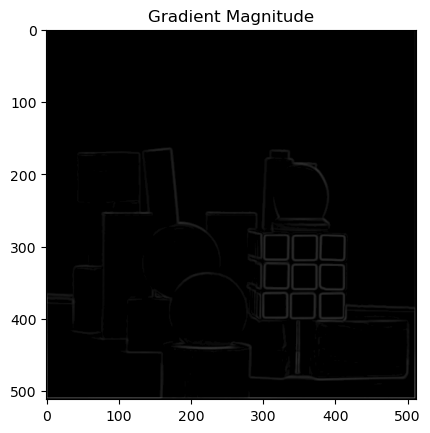

In [2]:
# Part 1. Compute the Gradient Magnitude
dX, dY = sobelConv(blocks)
magnitude = np.sqrt(dX[:,:]**2 + dY[:,:]**2)#compute magnitude from first derivative
threshold = 8.5 #threshold that picks up most edges between blocks but not grains in the wood
magnitude[magnitude<=threshold] = 0
plotImage(magnitude, "Gradient Magnitude")

# Show your results on the blocks image


I used my edge detection from learning lab 1 that makes use of the sobel kernels to find the gradient magnitude. From there I started playing around with a possible global threshold value on 100. I quickly realized this was to high and worked my way down. I eventually landed on the value 12.5 as I believe it found a health blend of detecting most edges between blocks while not picking up the grains of wood. That being said this is not a perfect solution but it seems to be a problems solved later in the lab by combining first derivative sobel kernels with second derivative laplacian kernels.

<br><b>A2. Gradient Orientation</b> - Compute a gradient orientation image for a grayscale image.  Encode the orientations as intensity using any method you wish. (Just make sure to document it.)  Hint: use atan2(), not atan(), to do the angle calculation.

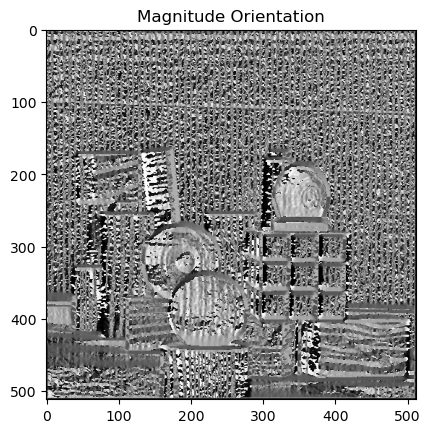

In [3]:
# Part 2. Compute the Gradient Orientation
orientation = np.arctan2(dY[:,:], dX[:,:])*(180/math.pi) # stored as degrees, not radians
plotImage(orientation, "Magnitude Orientation")
# Show your results on the blocks image

<br><b>A3. Laplacian Zero-Crossings</b> - Apply a 3x3 Laplacian kernel to blocks and find the zero crossings.



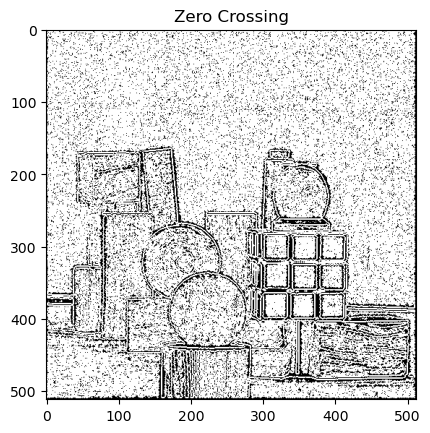

In [4]:
# Part 3. Find the Zero Crossings
def zeroCrossing(image):
    ret = np.zeros(image.shape)
    for r in range(1, image.shape[0]-1):
        for c in range(1, image.shape[1]-1):
            if image[r,c] == 0:
                ret[r,c] = 255
            elif (image[r,c] > 0 and image[r-1, c] < 0) or (image[r,c] < 0 and image[r-1, c] > 0):
                ret[r,c] = 255
            elif (image[r,c] > 0 and image[r+1, c] < 0) or (image[r,c] < 0 and image[r+1, c] > 0):
                ret[r,c] = 255
            elif (image[r,c] > 0 and image[r, c-1] < 0) or (image[r,c] < 0 and image[r, c-1] > 0):
                ret[r,c] = 255
            elif (image[r,c] > 0 and image[r, c+1] < 0) or (image[r,c] < 0 and image[r, c+1] > 0):
                ret[r,c] = 255
    return ret

lapKernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
laplacian = convolution(blocks, lapKernel)
zeroCross = zeroCrossing(laplacian)
plotImage(zeroCross, "Zero Crossing")
# Show the results on blocks image

<br><b>A4. Combine Gradient Magnitude and Zero-Crossings</b> - Use the gradient magnitude image computed in item 1 to select Laplacian zero-crossings in part 3 that correspond to points with gradients higher than some threshold that you determine.  Adjust your threshold to find the best solution.


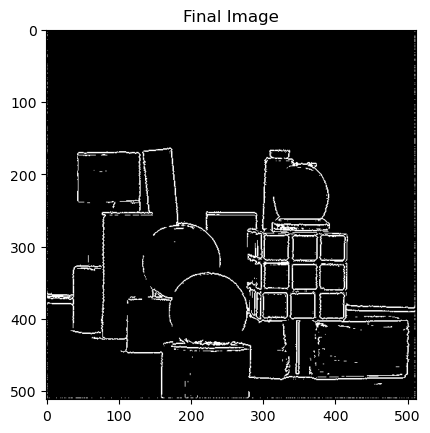

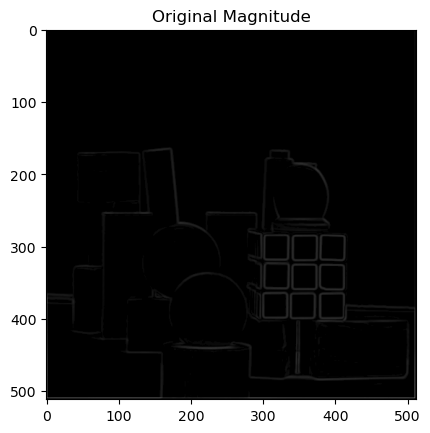

In [5]:
# Part 4. Final Solution
def combo(magnitude, crossing):
    ret = np.zeros(magnitude.shape)
    for r in range(magnitude.shape[0]):
        for c in range(magnitude.shape[1]):
            if magnitude[r,c] > 0 and crossing[r,c] > 0:
                ret[r,c] = 255
    return ret

finalImg = combo(magnitude, zeroCross)
plotImage(finalImg, "Final Image")
plotImage(magnitude, "Original Magnitude")

# Show the results on blocks image


##### Part A: Write-up

<span style="color:red">Please describe your results here and any questions, etc. above.</span>



When comparing the final result to that of the original gradient magnitude it is clear to see that one is better than the other. The final result has thinner and more defined edges. One of the most visual improvements of this is the small gap between the 2 blocks below the rubix cube. In the original this was just one thick shared edge but in the final result there are 2 distinct edges. I do have a few questions remaining though. The first being is the zero crossing supposed to have so many positive values? When determining if the value of the image was supposed to be a 0 or 255 I first checked if it was zero, otherwise I checked if the neighbors had different signs which implied a zero crossing was between the pixels. The other question was if there was a better way to handle the grains of wood? After I applied a mean filter I saw a dramatic improvement in the results but they were still impossible to eliminate while picking up a reasonable amount of edges.

<br><br><br>
#### Part B: Hough Transform (68 points)
Use the Hough transform to find all of the circular shapes in a color image.  They occur in three (approximate) sizes: 32, 64, and 96 pixels in diameter.  Try it out first on the simple <span style="color:orange;">simplecircle.png</span> image, then on the more complicated <span style="color:orange;">circles.png</span> image.

After finding maxima in the accumulator(s), write out a list of positions and sizes (small, medium, or large) for each circle.  Be aware that for some of the circles the center is outside the image--you should still be able to identify where it is.

Some of the cases are tricky--don't panic if you don't get them all at first. Keep trying to get as many as possible while generatign as few possible false positives (erroneous identifications).

About 40 of the 68 points will be on how many of the circles you can detect (1-2 false positives are okay). To know what you should be shooting for, there are:
* 5 small circles (blue/cyan, light gray, purple clipped on the left, two eyes of the pumpkin).
* 12 medium circles (green one in the top left corner, orange/magenta/pink near top/left, yello, magenta, purple/cyan, medium grey in "target", med blue clipped on the left, red/white/blue on lower right).
* 3 Large circles (black in target, black/dark blue on right, and orange pumpkin).

For the <span style="color:orange;">circles.png</span> file, and each of the 3 diameters, show (1) the accumulation array and (2) the <span style="color:orange;">circles.png</span> with the detected circles outlined.  This would be a total of 6 figures (3 diameters with two plots each).

This will be graded based on how well your method performs and how innovative your solution is. **In the write-up, describe any improvements/optimizations you made from the vanilla Hough transform**.

simplecircle.png:
![alt simplecircle.png](simplecircle.png)
circles.png:
![alt circles.png](circles.png)

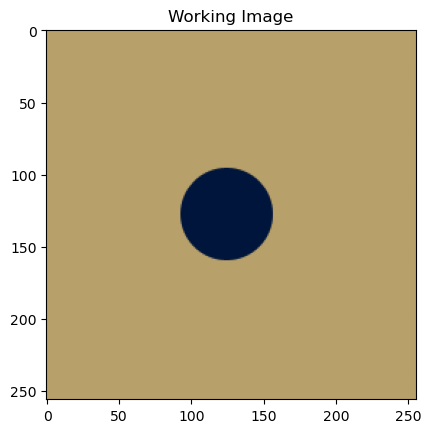

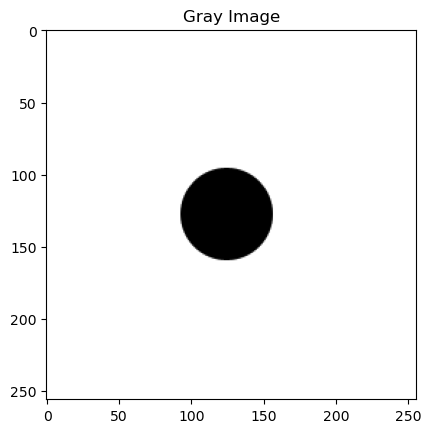

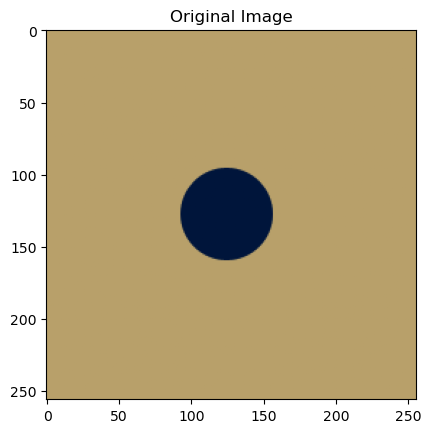

In [41]:
import cv2

def toGray(image):
    result = .299*image[:,:,0] + .587*image[:,:,1] + .144*image[:,:,2]
    return result

def filterImg(image):
    xLen,yLen,_ = image.shape
    result = cv2.medianBlur(image, 3)
    return result

origImg = plt.imread('simplecircle.png')
#origImg = plt.imread('circles.png')
# origImg = cv2.copyMakeBorder(origImg, 1, 1, 1, 1, cv2.BORDER_CONSTANT)
workImg = filterImg(origImg)
grayImg = toGray(origImg)
plt.imshow(workImg, cmap='gray');plt.title("Working Image");plt.show()
plt.imshow(grayImg, cmap='gray');plt.title("Gray Image");plt.show()
plt.imshow(origImg);plt.title("Original Image");plt.show()

In [42]:
#Finds the gradient magnitude for each color channel
dXR, dYR = sobelConv(workImg[:,:,0])
magR = np.sqrt(dXR[:,:]**2 + dYR[:,:]**2)
dXG, dYG = sobelConv(workImg[:,:,1])
magG = np.sqrt(dXG[:,:]**2 + dYG[:,:]**2)
dXB, dYB = sobelConv(workImg[:,:,2])
magB = np.sqrt(dXB[:,:]**2 + dYB[:,:]**2)
dX, dY = sobelConv(grayImg)


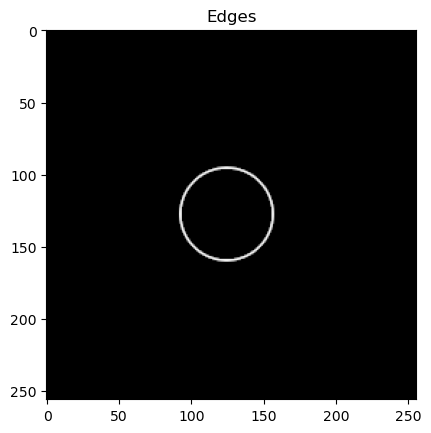

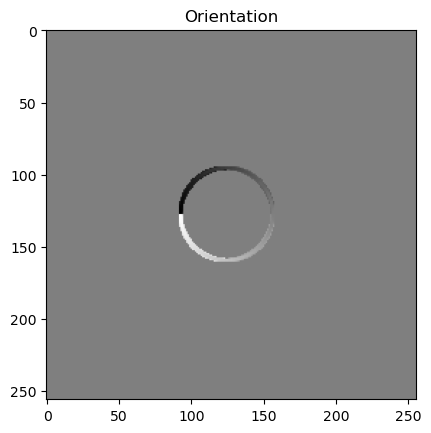

In [43]:
#Combines each channel into one image based off the max value
magnitude = np.maximum(magR, magG)
magnitude = np.maximum(magnitude, magB)
orientation = np.arctan2(dY[:,:], dX[:,:])*(180/math.pi)

threshold = .115
magnitude[magnitude<=threshold] = 0
plt.imshow(magnitude, cmap='gray');plt.title("Edges");plt.show()
plt.imshow(orientation, cmap='gray');plt.title("Orientation");plt.show()

In [ ]:
#Hough Transform
def voting(magnitude, radius, step=1):
    accum = np.zeros((magnitude.shape[0], magnitude.shape[1], radius.shape[0]))
    for r in range(accum.shape[0]):
        for c in range(accum.shape[1]):
            if magnitude[r,c] == 0: continue
            direction = round(orientation[r,c])
            negDirection = direction * -1
            radIndex = 0
            for k in radius:
                for n in range(direction-5, direction+5, step):
                    b = r - k * np.sin(n)
                    a = c - k * np.cos(n)
                    if a < accum.shape[0]-1 and b < accum.shape[1]-1 and a >= 0 and b >=0:
                        accum[round(a), round(b), radIndex] += 1
                for n in range(negDirection-5, negDirection+5, step):
                    b = r - k * np.sin(n)
                    a = c - k * np.cos(n)
                    if a < accum.shape[0]-1 and b < accum.shape[1]-1 and a >= 0 and b >=0:
                        accum[round(a), round(b), radIndex] += 1

                radIndex += 1
    return accum

radius = np.array([16, 32, 48])
votes = voting(magnitude, radius)
threshold = 18
votes[votes<=threshold] = 0

output = np.copy(workImg)
for r in range(votes.shape[0]):
    for c in range(votes.shape[1]):
        for k in range(3):
            if votes[r,c,k] > 0:
                output = cv2.circle(output, (r, c), radius[k], (1,0,.2), 2)
                votes[r-10:r+10, c-10:c+10, k] = 0
plt.imshow(output, cmap='gray');plt.show()
# Be sure to show all of the figures required in the description above

##### Part B: Write-up

<span style="color:red">Please describe your results here and any questions, etc. above.</span>

